In [19]:
import pandas as pd
import seaborn as sns
from pathlib import Path

We have a folder of csv files. Each csv file corresponds to one autotrack metric. Within each file, the rows correspond to patients and the columns correspond to bundles. 

We combine all of these dataframes into one dataframe with four columns: sub (patient), bundle, metric (which autotrack metric), score (score of this metric from autotrack)

In [2]:
path = '../../hcpd_selection_and_completeness/outputs/metrics'
source_files = sorted(Path(path).glob('*.csv'))

dfs = []
for file in source_files:
    df = pd.read_csv(file)
    df = pd.melt(df, ["sub"],
                       var_name="bundle", value_name="score")
    df['metric'] = file.name[:-4]
    dfs.append(df)

In [3]:
metrics = pd.concat(dfs)

In [22]:
metrics.head(0)

,sub,bundle,score,metric


We make another dataframe with the same data, but restructured to have all metrics as columns, to allow for correlation analysis. 

In [5]:
len(metrics)/metrics["metric"].nunique()

32032.0

In [6]:
metrics_long = metrics.pivot(columns="metric", values="score", index = ["sub", "bundle"]).reset_index().copy()

In [7]:
len(metrics_long)

32032

In [8]:
metrics_long.head(0)

metric,sub,bundle,ad,area_of_end_region_1_mm2,area_of_end_region_2_mm2,branch_volume_mm3,curl,diameter_mm,dti_fa,elongation,...,total_radius_of_end_regions_mm,total_surface_area_mm2,trunk_volume_mm3,txx,txy,txz,tyy,tyz,tzz,volume_mm3


In [17]:
corr = metrics_long.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

metric,ad,area_of_end_region_1_mm2,area_of_end_region_2_mm2,branch_volume_mm3,curl,diameter_mm,dti_fa,elongation,gfa,ha,irregularity,irregularity_of_end_region_1,irregularity_of_end_region_2,iso,md,mean_length_mm,nrdi02L,nrdi04L,nrdi06L,number_of_tracts,qa,radius_of_end_region_1_mm,radius_of_end_region_2_mm,rd,rd1,rd2,rdi,span_mm,total_area_of_end_regions_mm2,total_radius_of_end_regions_mm,total_surface_area_mm2,trunk_volume_mm3,txx,txy,txz,tyy,tyz,tzz,volume_mm3
metric,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ad,1.000000,-0.114754,-0.088746,-0.118380,0.310043,-0.376959,0.268523,0.567127,0.595966,-0.010737,-0.389115,0.414510,0.180803,-0.436182,0.822730,0.293888,-0.393241,-0.380852,0.254424,-0.011145,0.280129,-0.020476,-0.156754,0.504492,0.454027,0.540476,-0.385962,-0.006665,-0.106782,-0.116273,-0.104703,-0.021460,0.597423,0.029366,-0.041840,0.621921,0.091873,0.360440,-0.071085
area_of_end_region_1_mm2,-0.114754,1.000000,0.807030,0.511355,0.319364,0.842749,0.250617,-0.445832,0.195222,0.001511,0.659258,-0.213345,-0.232760,0.147287,-0.272013,0.086431,0.195638,0.122828,0.019585,0.864882,0.300953,0.601166,0.308220,-0.327658,-0.334835,-0.316797,0.216630,-0.158850,0.948579,0.596811,0.870813,0.837639,-0.012324,0.039822,0.017140,-0.377087,-0.037072,-0.066895,0.926369
area_of_end_region_2_mm2,-0.088746,0.807030,1.000000,0.440438,0.328336,0.789876,0.168489,-0.369701,0.114360,0.011442,0.572576,-0.205481,-0.209808,0.086683,-0.196719,0.181373,0.110036,0.067237,0.006134,0.883706,0.168727,0.337210,0.577899,-0.232673,-0.238411,-0.224410,0.122290,-0.088285,0.952452,0.600459,0.844540,0.858230,0.053012,0.037984,-0.005153,-0.195114,-0.141806,-0.201264,0.911591
branch_volume_mm3,-0.118380,0.511355,0.440438,1.000000,-0.003160,0.590504,0.047793,-0.292968,-0.018886,0.021637,0.733248,-0.026843,-0.004003,0.060285,-0.148601,0.132800,0.051973,0.005688,0.006613,0.531759,0.032552,0.639979,0.511480,-0.137501,-0.138110,-0.135002,0.066992,0.153018,0.499941,0.755630,0.690350,0.142482,-0.125824,0.036535,0.026213,-0.117499,-0.128394,-0.042689,0.568223
curl,0.310043,0.319364,0.328336,-0.003160,1.000000,0.213316,0.309954,0.036226,0.388613,-0.003582,-0.006287,0.005633,-0.038700,-0.043317,0.098766,0.207457,0.007268,-0.022030,0.050989,0.381369,0.309097,0.088046,0.103686,-0.081021,-0.117892,-0.048263,0.018009,-0.528302,0.340787,0.125814,0.273140,0.436347,0.408718,-0.005170,0.010855,-0.008290,-0.021914,-0.150828,0.361339
diameter_mm,-0.376959,0.842749,0.789876,0.590504,0.213316,1.000000,-0.060911,-0.736046,-0.172312,0.001046,0.872555,-0.313428,-0.280290,0.291685,-0.344128,-0.139349,0.284019,0.257066,0.011240,0.740149,0.034207,0.496278,0.451546,-0.241806,-0.235725,-0.243539,0.286396,-0.235713,0.858246,0.621985,0.835369,0.697424,-0.027649,0.021279,0.013693,-0.455605,-0.162350,-0.101027,0.845399
dti_fa,0.268523,0.250617,0.168489,0.047793,0.309954,-0.060911,1.000000,0.446357,0.911415,0.016180,-0.134453,0.009691,-0.011842,-0.188010,-0.320107,0.690744,-0.037224,-0.263323,-0.044034,0.351564,0.767260,0.207186,-0.000417,-0.686323,-0.708578,-0.657384,0.043589,0.334810,0.219630,0.135727,0.283574,0.308005,-0.292343,0.051588,-0.050121,-0.078331,-0.128859,-0.293747,0.277558
elongation,0.567127,-0.445832,-0.369701,-0.292968,0.036226,-0.736046,0.446357,1.000000,0.560674,0.007067,-0.665981,0.403194,0.346409,-0.348992,0.307295,0.599346,-0.283340,-0.352028,0.037362,-0.242578,0.312505,-0.218441,-0.185270,0.044148,0.026459,0.058668,-0.251362,0.413435,-0.428214,-0.264927,-0.357459,-0.293406,0.061810,0.009227,-0.020166,0.399865,-0.009653,0.066104,-0.375693
gfa,0.595966,0.195222,0.114360,-0.018886,0.388613,-0.172312,0.911415,0.560674,1.000000,0.008176,-0.258703,0.152761,0.023529,-0.286608,0.048585,0.674231,-0.129337,-0.293051,0.050632,0.297920,0.777391,0.185717,-0.110017,-0.370308,-0.397173,-0.341964,-0.067508,0.248282,0.162032,0.049735,0.208278,0.279358,0.030708,0.052096,-0.075305,0.138713,-0.000083,-0.103431,0.223752


<Axes: xlabel='metric', ylabel='metric'>

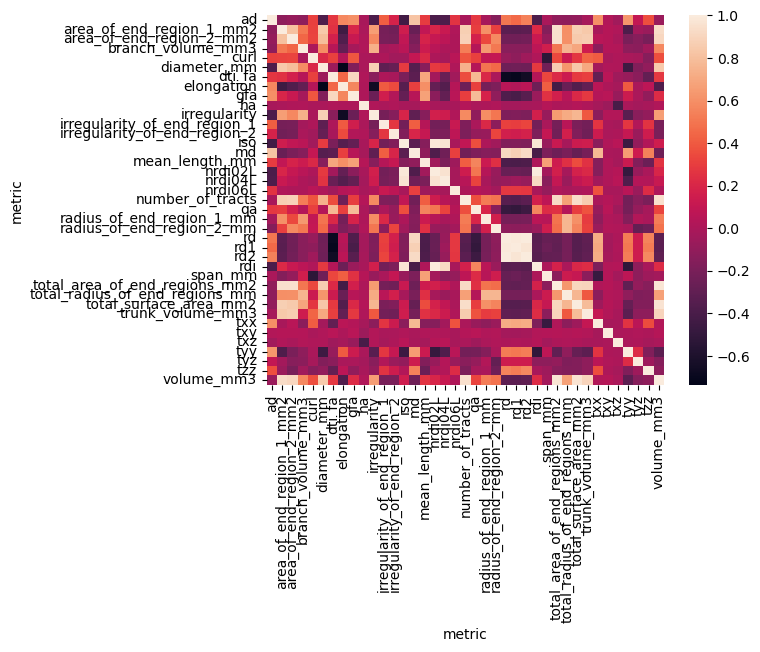

In [20]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

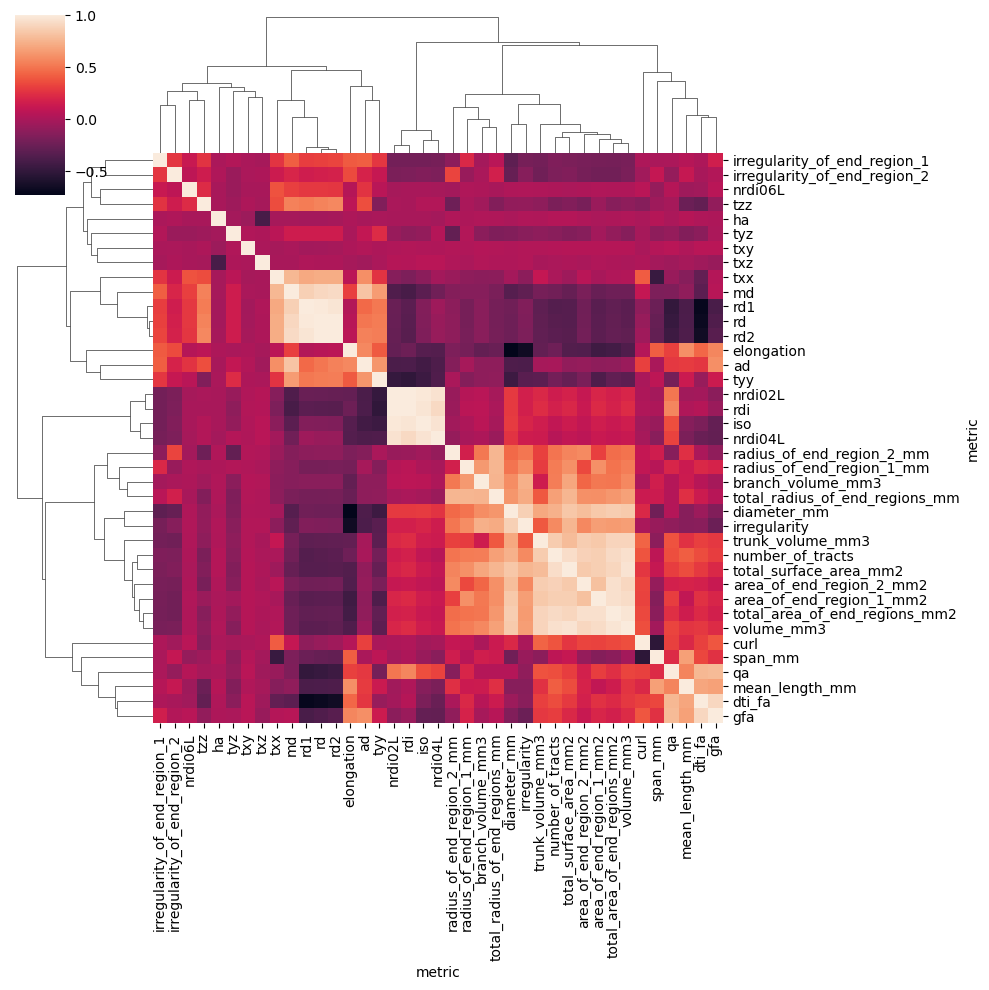

In [21]:
sns.clustermap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)